In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

C:\Users\Anup\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H, n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)
    
    return J_content

In [3]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [4]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))

    return J_style_layer

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [7]:
def total_cost(J_content, J_style, alpha = 30, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [24]:
content_image = imageio.imread("images/cat1.jpg")
imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

In [25]:
style_image = imageio.imread("images/st.jpg")
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


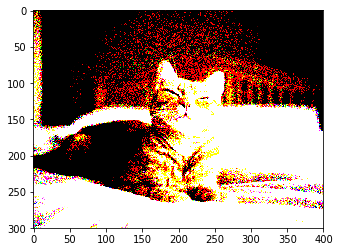

In [26]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [12]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

In [13]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [14]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [15]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

In [16]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [17]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###
        
        """
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("f4/" + str(i) + ".png", generated_image)
        """
        print("Iteration: " + str(i))
    # save last generated image
    save_image('output/generated_image3.jpg', generated_image)
    
    return generated_image

In [18]:
model_nn(sess, generated_image)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

array([[[[ 3.3508064e+01,  2.0494390e+01,  3.5059944e+01],
         [-1.2334330e+01, -6.5911476e+01,  5.3106178e+01],
         [-6.0966316e+01, -4.2270321e+01,  7.1106102e+01],
         ...,
         [-4.4331211e+01, -3.7011566e+01, -6.8243172e+01],
         [-4.3092945e+01, -2.7362947e+01, -5.6654217e+01],
         [ 2.4899006e+00, -6.5263376e+00, -2.1798597e+01]],

        [[ 5.4451180e+00, -6.2033001e+01,  4.1797085e+01],
         [-6.0531551e+01, -5.2539665e+01,  2.0851336e+00],
         [-5.4197090e+01, -2.8718740e+01,  1.5843493e+01],
         ...,
         [-6.9555428e+01, -6.3816647e+01, -4.5436527e+01],
         [-2.1218834e+01, -2.1899632e+01, -3.4433132e+01],
         [ 2.4272888e+00, -1.3977898e+00, -1.2308309e+01]],

        [[-5.2787315e+01, -6.0896420e+01,  3.0659168e+01],
         [-5.2366978e+01, -3.2979858e+01, -1.4965557e+01],
         [-3.0248745e+01, -3.2844246e+01,  6.0371292e+01],
         ...,
         [-6.0135513e+01, -3.9166546e+01, -3.6772427e+01],
         [

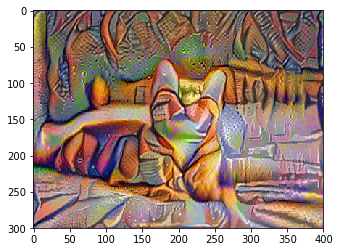

In [23]:
i = imageio.imread('output/generated_image3.jpg')
imshow(i)